# Logistic Regression from Scratch


A researcher might be interested in knowing what
makes a successful politician. For the purpose of this blog post, "success"
means the probability of winning an election. In that case, it would be sub-optimal
to use a linear regression model to see what factors are associated with successful
politicians, since the outcome variable is binary (a politician either wins or loses an election).
The linear model is built around the idea that the outcome variable is continuous. What if
the statistician tries to sees what factors are influencing the **probability** of
winning? This strategy naturally lends itself to using a [logistic model](https://en.wikipedia.org/wiki/Logistic_regression) (or a [probit](https://en.wikipedia.org/wiki/Probit_model)).
In this blog post, I derive the logistic model from scratch and show how one
can estimate its parameters.

## The logistic model

The outcome variable $y_i$ is either $1$ ("winning") or $0$ ("losing"). The logistic
model makes the assumption that the probability of winning is given by the logistic
function :

$$ f(y_i | x_{i}, \theta_{i}) =  \sigma(x_{i} '\theta)$$

with $\sigma(v) = \frac{exp(v)}{1+exp(v)}$

The probability of losing is 1 minus the probability of wining:

$$ f(y_i | x_{i}, \theta) =  1 - \sigma(x_{i} '\theta)$$

## A latent variable formulation

## Log-likelihood function

To understand what makes a successful politician (or to predict who is going to win the next elections), one must estimate the value of $\theta$ using the information contained in the sample $(y_i, x_i)_{i=1}^{N}$. One "natural" criterion is to find the value for $\theta$ that **maximizes the probability of observing the
sample**. This procedure is called [Maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation). Let us assume that sample is [i.i.d](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables). If the i.i.d assumption holds, the probability of observing the $(y_i, x_i)_{i=1}^{N}$ is the product of the probability of observing each observation. Instead of maximizing the likelihood, it is more convenient to maximize the log-likelihood, which transforms the product of probabilities into a sum:

$$ L((y_i, x_i)_{i=1}^{N};\theta) = log( \prod_{i=1}^{N}f(y_i | x_{i}, \theta)) = \sum_{i=1}^{N} log(f(y_i | x_{i}, \theta_{i}))$$

The probability of observing $y_i$  can be compactly written as

$$ f(y_i | x_{i}, \theta_{i}) = \sigma(x_{i} '\theta)^{y_i}(1 - \sigma(x_{i} '\theta))^{1 - y_i} $$

Hence, the log-likelihood function writes:

$$L((y_i, x_i)_{i=1}^{N};\theta) = \sum_{i=1}^{N} y_i log(\sigma(x_{i} '\theta)) + (1 - y_i)log(1 - \sigma(x_{i} '\theta))$$

## Maximum Likelihood Estimation

Taking the derivative of $f(y_i | x_{i}, \theta)$ with respect to the parameter $\theta$ gives:

$$ f_{\theta}(y_i | x_{i}, \theta) = [y_i - \sigma(x_{i} '\theta)] x_{i} $$

and the derivative of the log-likelihood function with respect to $\theta$ is:

$$L_{\theta}((y_i, x_i)_{i=1}^{N};\theta) = \sum_{i=1}^{N}[y_i - \sigma(x_{i} '\theta)] x_{i}$$


## Gradient descent

To make the link with this [blog post](https://julienpascal.github.io/post/ols_ml/), let us use gradient descent to find the MLE estimate:

$$ \theta_{i+1} = \theta_{i} - \gamma \Big(- L_{\theta}((y_i, x_i)_{i=1}^{N};\theta_{i}) \Big)$$


The [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) algorithm is an iterative procedure to find a minimizer of function. At each step, the algorithm takes a step of length $\gamma$ towards the direction of steepest descent. Note that I reformulated the problem of finding the maximum of a function $f$ (the log-likelihood) as the problem of finding the minimum of $-f$.

## Implementation in Julia

Let's load a few dependencies:

In [7]:
using Distributions
using Plots
pyplot()
using DataFrames
using GLM
using Optim
using CSV

Let's create the logistic function:

In [8]:
# Logistic function for a scalar input:
function sigma(x::Float64)
    exp(x)/(1.0 + exp(x))
end

# Logistic function for a vector input:
#function sigma(x::Array{Float64,1})
#    exp.(x) ./ (1.0 .+ exp.(x))
#end

sigma (generic function with 1 method)

In [9]:
#function(z){1/(1+exp(-z))}
    
# Logistic function for a scalar input:
function sigma(x::Float64)
   1.0/(1.0 + exp(-x))
end

# Logistic function for a vector input:
#function sigma(x::Array{Float64,1})
#    1.0 ./ (1.0 .+ exp.(-x))
#end

sigma (generic function with 1 method)

In [10]:
transpose(ones(3))*ones(3)

3.0

Function for the likelihood:

In [11]:
function log_likelihood(y::Array{Float64,1}, X::Array{Float64,2}, theta::Array{Float64,1})
    sum = 0.0
    #Loop over individuals in the sample
    for i=1:size(X,1)
        sum += y[i]*log(sigma(transpose(X[i,:])*theta)) + (1.0 - y[i])*log(1.0 - sigma(transpose(X[i,:])*theta))
    end
    return (1/size(X,1))*sum
end

log_likelihood (generic function with 1 method)

Let's create a function that returns the derivative of the log-likelihood of the sample, which we need for the gradient descent algorithm:

In [70]:
# Function to calculate the derivative of the log-likelihood of the sample:
function derivative_log_likelihood(y::Array{Float64,1}, X::Array{Float64,2}, theta::Array{Float64,1})
    sum = zeros(size(X,2))
    #Loop over individuals in the sample
    for i=1:size(X,1)
        sum .+= (y[i] - sigma(transpose(X[i,:])*theta))*X[i,:]
    end
    return sum
end

derivative_log_likelihood (generic function with 1 method)

Let's simulate a sample of individuals:

In [74]:
#Generation of a sample:
#----------------------
N_individuals = 10000 #how many individuals in the sample?
dim_X = 3 #How many dimensions for x
d = Normal(0.0, 1.0)
# Generate true parameter values:
theta0 = [0.5; 1; 2]

3-element Array{Float64,1}:
 0.5
 1.0
 2.0

In [78]:
# Generate X:
X = rand(d, N_individuals, dim_X)
# The first column is full one ones (to have a constant)
X[:,1] = ones(N_individuals);

In [80]:


# Generate the y:
#proba_success = sigma(X*theta0)
#y = ifelse.(proba_success.>0.5, 1.0, 0.0);

# Convert y to a binary outcome
proba_success = X*theta0 .+ rand(d, N_individuals)
y = ifelse.(proba_success .> 0.0, 1.0, 0.0);

In [ ]:
#for i=1:dim_X
#    X[:,i] = (X[:,i] .- mean(X[:,i]))./std(X[:,i])
#end

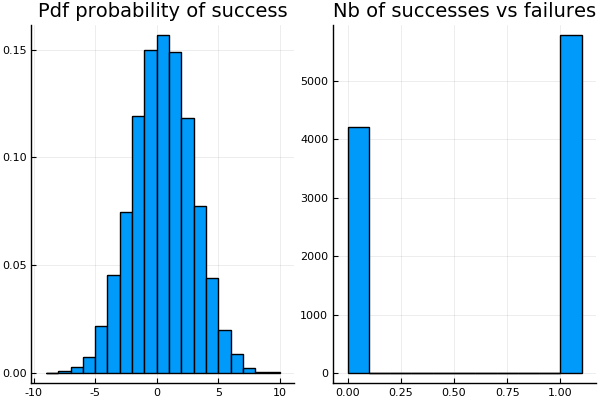

In [81]:
p1 = histogram(proba_success, bins=20, normalize=true, title="Pdf probability of success", legend=false)
p2 = histogram(y, title="Nb of successes vs failures", legend=false)
plot(p1,p2)

### Maximization with Optim

In [82]:
theta_guess = ones(dim_X)
res = optimize(theta -> - log_likelihood(y, X, theta), theta_guess, LBFGS())

 * Status: success

 * Candidate solution
    Minimizer: [8.70e-01, 1.79e+00, 3.53e+00]
    Minimum:   2.865011e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [1.00e+00, 1.00e+00, 1.00e+00]

 * Convergence measures
    |x - x'|               = 5.29e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.50e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.54e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.93e-10 ≰ 0.0e+00
    |g(x)|                 = 1.43e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    8
    f(x) calls:    25
    ∇f(x) calls:   25


In [83]:
res.minimizer

3-element Array{Float64,1}:
 0.8699160539267676
 1.7918614571206264
 3.5299259015142073

In [84]:
coeff = mean(theta0./res.minimizer)
res.minimizer.* coeff

3-element Array{Float64,1}:
 0.4927874638768599
 1.0150483590770731
 1.9996219460813187

### Minimization with Newton-Raphson

### Minimization with gradient descent

Let's implement the gradient descent algorithm within a function:

In [19]:
function gradient_descent_probit(y, X , theta_initial::Array{Float64,1}; max_iter::Int64 = 1000, 
                                learning_rate::Float64 = 0.000001, tol::Float64=0.01)
    #initial value for theta:
    theta_old = theta_initial
    theta_new = similar(theta_old)
    #convergence reached?
    success_flag = 0
    #Let's store the convergence history
    history= fill!(zeros(max_iter), NaN)
    for i=1:max_iter 
        theta_new = theta_old + learning_rate*derivative_log_likelihood(y, X, theta_old)
        diff = maximum(abs, theta_new .- theta_old)
        history[i] = diff
        if diff < tol
            success_flag = 1
            break
        end
        theta_old = theta_new
    end
    
    return theta_new, success_flag, history[isnan.(history) .== false]
    
end

gradient_descent_probit (generic function with 1 method)

In [20]:
theta_guess = ones(dim_X)
theta, flag, history = gradient_descent_probit(y, X, theta_guess, max_iter=100000, learning_rate=0.000001, tol=0.001);

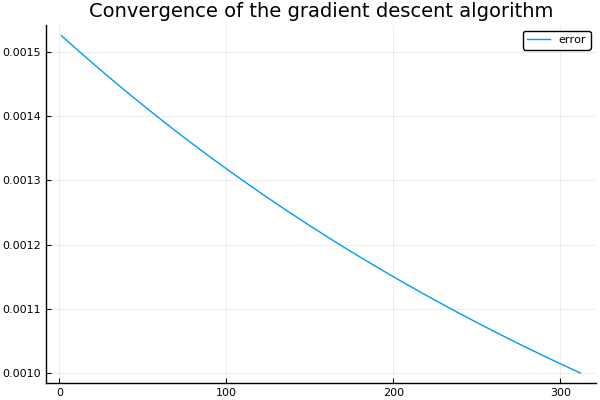

In [21]:
plot(history, label= "error", title = "Convergence of the gradient descent algorithm")

In [22]:
proba_success_predicted = sigma(X*theta)
# Convert y to a binary outcome
y_predicted = ifelse.(proba_success_predicted .>0.5, 1.0, 0.0);

MethodError: MethodError: no method matching sigma(::Array{Float64,1})
Closest candidates are:
  sigma(!Matched::Float64) at In[9]:5

In [23]:
theta 

3-element Array{Float64,1}:
 0.7936395072059673
 1.0043255908022524
 1.3847982895447217

In [24]:
theta0

3-element Array{Float64,1}:
 0.5
 1.0
 2.0

Parameters are identified up to a scale: 
[EXPLAIN MORE USING LATENT VARIABLES]

In [25]:
coeff = mean(theta0./theta)
theta.* coeff

3-element Array{Float64,1}:
 0.8121460324012888
 1.0277450106795751
 1.4170897823487039

We don't need the scale to make accurate predictions:

In [26]:
histogram(y_predicted - y)

UndefVarError: UndefVarError: y_predicted not defined

## Other test

In [36]:
using DataFrames, GLM
N=1000
distX = Normal(0,1)

X1 = rand(distX,N);
X2 = rand(distX,N);
ɛ = randn(N);
y = X1 .+ X2 .>ɛ;
y_int = ifelse.(y .== true, 1.0, 0.0)
df = DataFrame(X1=X1,X2=X2, y=y);

In [38]:
df = DataFrame(X1=X[:,1],X2=X[:,2], y=y_int)

DimensionMismatch: DimensionMismatch("column length 10000 for column(s) X1 and X2, and is incompatible with column length 1000 for column(s) y")

In [29]:
first(df,6)

,X1,X2,y
,Float64,Float64,Bool
1,-0.149016,0.412382,true
2,-0.138814,-0.17516,false
3,0.063702,-1.45114,false
4,1.86973,-1.9381,false
5,-1.07935,0.353437,true
6,-1.25978,0.155787,false


In [30]:
fittedmodel = glm(@formula(y ~ X2 + X3), df, Binomial(), ProbitLink(), verbose=true);

ErrorException: type NamedTuple has no field X3

In [ ]:
coef(fittedmodel)

Let's create a X matrix with a constant:

In [ ]:
X = hcat(ones(N), X1,X2)

In [ ]:
theta_guess = zeros(3)
theta, flag, history = gradient_descent_probit(y_int, X, theta_guess, max_iter=100000, learning_rate=0.000001, tol=0.001);

In [ ]:
theta

## NBA data

I use the data set on NBA shots taken during the 2014-2015 season.
It contains information on who took the shot, where on the floor was the shot taken from, who was the nearest defender, 
how far away was the nearest defender, time on the shot clock, etc. 
The data is available on Kaggle [here](https://www.kaggle.com/dansbecker/nba-shot-logs)

In [39]:
df_nba = CSV.read("/home/julien/Documents/REPOSITORIES/LogisticRegression/data/shot_logs.csv");

In [40]:
names(df_nba)

21-element Array{Symbol,1}:
 :GAME_ID                   
 :MATCHUP                   
 :LOCATION                  
 :W                         
 :FINAL_MARGIN              
 :SHOT_NUMBER               
 :PERIOD                    
 :GAME_CLOCK                
 :SHOT_CLOCK                
 :DRIBBLES                  
 :TOUCH_TIME                
 :SHOT_DIST                 
 :PTS_TYPE                  
 :SHOT_RESULT               
 :CLOSEST_DEFENDER          
 :CLOSEST_DEFENDER_PLAYER_ID
 :CLOSE_DEF_DIST            
 :FGM                       
 :PTS                       
 :player_name               
 :player_id                 

The dataset is quite extensive. Let's select whether or not the shot was successful, the shot clock, the shot distance, and the proximity with the closest defender :

In [93]:
df_nba = df_nba[[:SHOT_RESULT, :SHOT_CLOCK, :SHOT_DIST, :CLOSE_DEF_DIST]]
# Drop rows with missings:
df_nba = dropmissing(df_nba);
# Drop rows with NaN:
df_nba = df_nba[completecases(df_nba), :]
# Convert SHOT_RESULT to a binary variable (1 for success, 0 for missed)
df_nba[:, :SHOT_RESULT] = ifelse.(df_nba[:SHOT_RESULT] .== "made", 1.0, 0.0);
# Show the first few rows:
first(df_nba, 6)

,SHOT_RESULT,SHOT_CLOCK,SHOT_DIST,CLOSE_DEF_DIST
,Float64,Float64,Float64,Float64
1,0.0,10.8,7.7,1.3
2,0.0,3.4,28.2,6.1
3,0.0,10.3,17.2,3.4
4,0.0,10.9,3.7,1.1
5,0.0,9.1,18.4,2.6
6,0.0,14.5,20.7,6.1


Create a binary variable:

In [43]:
y = convert(Array, df_nba[:SHOT_RESULT]);

In [44]:
X = convert(Matrix, df_nba[[:SHOT_CLOCK, :SHOT_DIST, :CLOSE_DEF_DIST]])
X = hcat(ones(size(X,1)), X);

In [45]:
log_likelihood(y, X, zeros(size(X,2)))

-0.6931471805586445

In [46]:
theta_guess = zeros(size(X,2))
res = optimize(theta -> - log_likelihood(y, X, theta), theta_guess, LBFGS())

 * Status: success

 * Candidate solution
    Minimizer: [-5.75e-02, 1.85e-02, -5.97e-02,  ...]
    Minimum:   6.634741e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 1.78e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.64e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.46e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.43e-11 ≰ 0.0e+00
    |g(x)|                 = 8.89e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    10
    f(x) calls:    37
    ∇f(x) calls:   37


In [59]:
res.minimizer

4-element Array{Float64,1}:
 -0.057512980272941105
  0.018519865965349713
 -0.059745060212410064
  0.10839221737959787 

In [60]:
log_likelihood(y, X, res.minimizer)

-0.663474116953469

In [62]:
log_likelihood(y, X, res.minimizer.* 1)

-0.663474116953469

In [63]:
fittedmodel = glm(@formula(SHOT_RESULT ~ SHOT_CLOCK + SHOT_DIST + CLOSE_DEF_DIST), df_nba, Binomial(), LogitLink(), verbose=true);

Iteration: 1, deviance: 162553.8624350455, diff.dev.:135.52181823542924
Iteration: 2, deviance: 162553.81255007617, diff.dev.:0.04988496933947317


In [64]:
coef_GMM = coef(fittedmodel)

4-element Array{Float64,1}:
 -0.057512702715234724
  0.01851984333927924 
 -0.05974499996244529 
  0.10839207775566419 

## References
* https://rpubs.com/junworks/Understanding-Logistic-Regression-from-Scratch